In [49]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn 
import sklearn.linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv("./heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1],  
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50);

In [5]:
def calcSqDistances(X, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]
    sqDmat = np.zeros((N,K))

    for n in range(N):
        for k in range(K):
            sqDmat[n][k] = (X[n][0] - Kmus[k][0])**2 + (X[n][1] - Kmus[k][1])**2
    return sqDmat


In [6]:
def determineRnk(sqDmat):
    N, K = np.shape(sqDmat)    
    Rnk = np.zeros(np.shape(sqDmat))
    min_inds = np.argmin(sqDmat,axis=1)
    for n in range(N):
        for k in range(K):
            temp = sqDmat[n]
            if k == np.argmin(temp):
                Rnk[n][k] = 1
            else:
                Rnk[n][k] = 0
    return Rnk

In [7]:
def recalcMus(X, Rnk):
    K = np.shape(Rnk)[1]
    N, D = np.shape(X)    
    Kmus = np.zeros((K,D))
    
    for k in range(K):
        sum1 = [0,0]
        sum2 = 0
        for n in range(N):
            sum1[0] += Rnk[n][k] * X[n][0]
            sum1[1] += Rnk[n][k] * X[n][1]            
            sum2 += Rnk[n][k]
        Kmus[k][0] = sum1[0] / sum2
        Kmus[k][1] = sum1[1] / sum2
    #one_inds = np.argmax(Rnk,axis=0)
    
    #for k in range(K):
    #    Kmus[k] = X[one_inds[k]]
    return Kmus


In [8]:
def runKMeans(K, data):
    # Load data file specified by fileStringfrom Bishop book
    X = data

    # Determine and store data set information
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;
    i = 0
    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster
        # center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set as 
        # per Bishop (9.2)
        # Specifically, the n,k entry is 1 if point n is closest to cluster k,
        # and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus

        # Recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)
        i = iter
        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break
    
    return determineRnk(calcSqDistances(X,Kmus)), Kmus
    

In [37]:
np_df = np.array(df.iloc[:,:-1])
Rnk, Kmus = runKMeans(5,np_df)

In [38]:
print(np.sum(Rnk[:,0]), np.sum(Rnk[:,1]))

27.0 93.0


In [39]:
print(np.sum(df.iloc[:,-1]))

96


In [40]:
print("Percent Accurate to DEATH_EVENT = 1: ", 100 - np.sum(abs(Rnk[:,1] - df.iloc[:,-1])) / df.shape[0] * 100, "%")

Percent Accurate to DEATH_EVENT = 1:  50.836120401337794 %


In [41]:
print("Percent Accurate to DEATH_EVENT = 1: ", 100 - np.sum(abs(Rnk[:,0] - df.iloc[:,-1])) / df.shape[0] * 100, "%")

Percent Accurate to DEATH_EVENT = 1:  67.55852842809364 %


In [42]:
clf = sklearn.linear_model.LogisticRegression(random_state=0).fit(df.iloc[:,:-1], df.iloc[:,-1])
clf.predict(df.iloc[:,:-1])
clf.score(df.iloc[:,:-1], df.iloc[:,-1])
print("Percent Accurate to DEATH_EVENT = 1: ", clf.score(df.iloc[:,:-1], df.iloc[:,-1]) * 100, "%")

Percent Accurate to DEATH_EVENT = 1:  82.2742474916388 %


In [43]:
kmeans.labels_.shape

(299,)

In [44]:
Rnk[:,1].shape

(299,)

## Kmeans using sklearn

In [45]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df.iloc[:,:-1])
check = df.iloc[:, -1].to_numpy()
## ask about convention
print(accuracy_score(check, kmeans.labels_))
check2 = 1-check
print(accuracy_score(check2, kmeans.labels_))
print(accuracy_score(check, Rnk[:,0]))
print(accuracy_score(check, Rnk[:,1]))

0.6220735785953178
0.3779264214046823
0.6755852842809364
0.5083612040133779


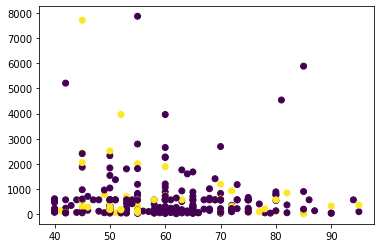

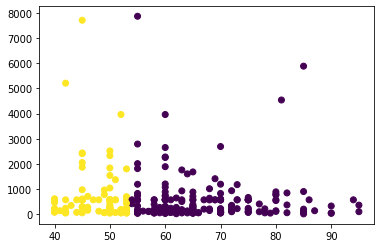

In [46]:
# creatine age
plt.scatter(df.iloc[:,0], df.iloc[:,2], c=kmeans.labels_)
plt.show()
plt.scatter(df.iloc[:,0], df.iloc[:,2], c=Rnk[:,1])

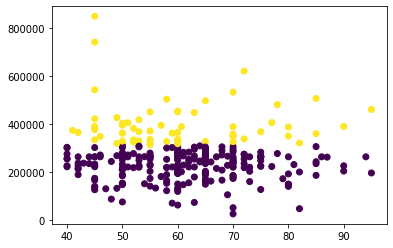

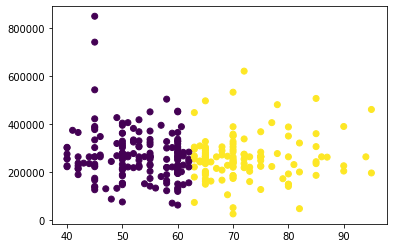

In [33]:
# platelettes age could be used in write up
plt.scatter(df.iloc[:,0], df.iloc[:,6], c=kmeans.labels_)
plt.show()
plt.scatter(df.iloc[:,0], df.iloc[:,6], c=Rnk[:,1])

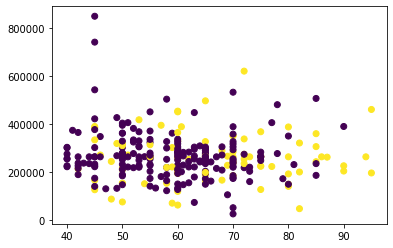

In [34]:
# platelettes age, authentic assignements
plt.scatter(df.iloc[:,0], df.iloc[:,6], c=df.iloc[:,-1])
plt.show()


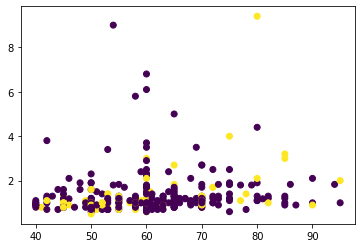

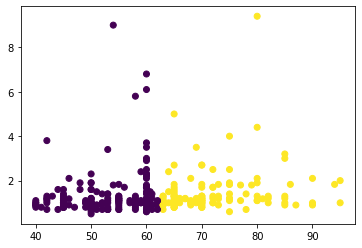

In [35]:
# serum creatine age
plt.scatter(df.iloc[:,0], df.iloc[:,7], c=kmeans.labels_)
plt.show()
plt.scatter(df.iloc[:,0], df.iloc[:,7], c=Rnk[:,1])

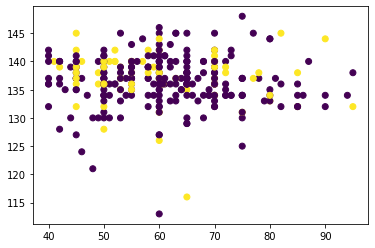

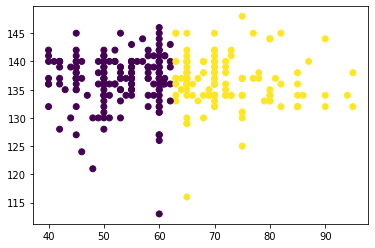

In [36]:
# serum sodium age
plt.scatter(df.iloc[:,0], df.iloc[:,8], c=kmeans.labels_)
plt.show()
plt.scatter(df.iloc[:,0], df.iloc[:,8], c=Rnk[:,1])

In [53]:
X_unscaled = df.to_numpy()
scaler = StandardScaler().fit(X_unscaled)
X = scaler.transform(X_unscaled)

pca = PCA().fit(X)
pcs = pca.transform(X)
X.shape

(299, 13)

In [57]:
death_ind = df.index[df['DEATH_EVENT'] == 1].tolist()
nodeath_ind = df.index[df['DEATH_EVENT'] == 0].tolist()

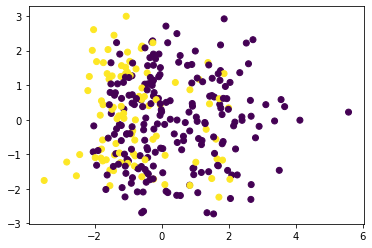

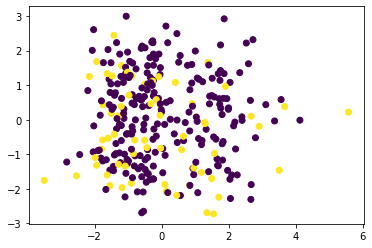

In [55]:
plt.scatter(pcs[:,0], pcs[:,1], c=Rnk[:,1])
plt.show()
plt.scatter(pcs[:,0], pcs[:,1], c=kmeans.labels_)

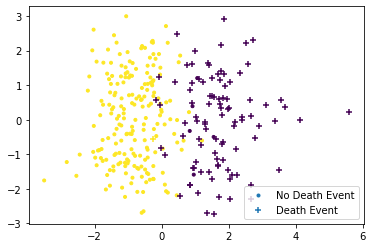

In [79]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.scatter(pcs[nodeath_ind,0], pcs[nodeath_ind,1], c=kmeans.labels_[nodeath_ind],marker='.',label="No Death Event")
plt.scatter(pcs[death_ind,0], pcs[death_ind,1], c=kmeans.labels_[death_ind],marker='+',label="Death Event")
plt.legend()
plt.show()

(299, 2)
0
1
[0. 1.]


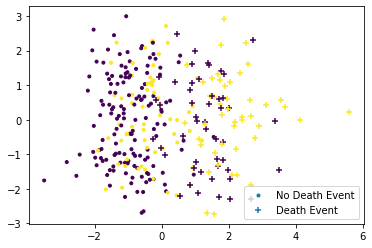

In [80]:
Rnk, Kmus = runKMeans(2,X)
print(Rnk.shape)
labels = np.zeros(Rnk.shape[0])
for i in range (Rnk.shape[1]):
    print(i)
    labels[Rnk[:,i] == 1] = i
print(np.unique(labels))
plt.scatter(pcs[nodeath_ind,0], pcs[nodeath_ind,1], c=labels[nodeath_ind],marker='.',label="No Death Event")
plt.scatter(pcs[death_ind,0], pcs[death_ind,1], c=labels[death_ind],marker='+',label="Death Event")
plt.legend()
plt.show()

In [82]:
pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]

0.28398973256510107

In [83]:
pca.explained_variance_ratio_

array([0.15622596, 0.12776378, 0.10093015, 0.0891262 , 0.07928468,
       0.07699103, 0.06985781, 0.06502326, 0.05907925, 0.05446994,
       0.05277144, 0.03950762, 0.02896889])

In [84]:
pcs

array([[ 3.11211975,  0.43557723, -0.56825801, ...,  0.36174189,
        -0.98740682,  0.27596169],
       [ 1.00800314,  1.98754397, -2.52749643, ...,  2.52784034,
        -0.07193827,  0.08434969],
       [ 2.5294976 ,  2.21890654, -0.78642159, ..., -0.8013464 ,
         0.4146901 ,  0.35646958],
       ...,
       [-3.50183761, -1.75889898, -1.53559353, ...,  0.82580238,
        -0.1927668 , -1.0797582 ],
       [-2.02708583,  2.60689646, -0.38222895, ...,  0.1239257 ,
         1.06139191, -0.53084699],
       [-1.93779849,  1.68167035,  0.14730457, ..., -0.118833  ,
         0.2414022 , -0.87182663]])